<font size="10">ANÁLISE DE SENTIMENTO COM TF-IDF</font>

In [1]:
# Bibliotetas usadas


import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
import re, os
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [2]:
seed = 7
np.random.seed(seed)

# O model será exportado para este arquivo
filename='model_saved.h5'


epochs = 5
#epochs = 6

# Dimensionalidade do word embedding pré-treinado
word_embedding_dim = 50

# Número de amostras a serem utilizadas em cada atualização do gradiente
batch_size = 32

# Quantidade máxima de palavras que iremos manter no vocabulário
max_fatures = 5000
#max_fatures = 6000

# Dimensão de saída da camada Embedding
embed_dim = 128

# Limitação do tamanho máximo de todas as sentenças
max_sequence_length = 300

In [3]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')


    return string.strip().lower()


In [4]:
def prepare_data(data):
    
    data = data[['label','preprocessed_news']]

    data['preprocessed_news'] = data['preprocessed_news'].apply(lambda x: x.lower())
    data['preprocessed_news'] = data['preprocessed_news'].apply(lambda x: clean_str(x))
    data['preprocessed_news'] = data['preprocessed_news'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    
    stop_words = set(stopwords.words('english'))
    text = []
    for row in data['preprocessed_news'].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [w for w in word_list if not w in stop_words]
        no_stop_words = " ".join(no_stop_words)
        text.append(no_stop_words)


    tokenizer = Tokenizer(num_words=max_fatures, split=' ')

    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)  
    
    X = pad_sequences(X, maxlen=max_sequence_length)

    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['label']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer


In [5]:
data = pd.read_csv('pre-processed.csv')

X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

<ipython-input-4-16558e1f9422>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['preprocessed_news'] = data['preprocessed_news'].apply(lambda x: x.lower())
<ipython-input-4-16558e1f9422>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['preprocessed_news'] = data['preprocessed_news'].apply(lambda x: clean_str(x))
<ipython-input-4-16558e1f9422>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

(5760, 300) (5760, 2)
(1440, 300) (1440, 2)


In [6]:
# Modelo

def model():
    input_shape = (max_sequence_length,)
    model_input = Input(shape=input_shape, name="input", dtype='int32')    
    embedding = Embedding(max_fatures, embed_dim, input_length=max_sequence_length, name="embedding")(model_input)
    lstm = LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="lstm")(embedding)
    model_output = Dense(2, activation='softmax', name="softmax")(lstm)
    model = Model(inputs=model_input, outputs=model_output)
    return model


In [7]:
# Execução do modelo
model = model()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

if not os.path.exists('./{}'.format(filename) ):

    hist = model.fit(
        X_train, 
        Y_train, 
        validation_data=(X_test, Y_test),
        epochs=epochs,
        batch_size=batch_size, 
        shuffle=True,
        verbose=1)

    model.save_weights(filename)    


    # Plot
    plt.figure()
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('Classificador de sentimentos')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend(loc='upper right')
    plt.show()

    plt.figure()
    plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title('Classificador de sentimentos')
    plt.xlabel('Epochs')
    plt.ylabel('Acurácia')
    plt.legend(loc='upper left')
    plt.show()

else:
    model.load_weights('./{}'.format(filename) )    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 softmax (Dense)             (None, 2)                 258       
                                                                 
Total params: 771,842
Trainable params: 771,842
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# Acuracidade do modelo

scores = model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print("Acc: %.2f%%" % (scores[1]*100))

Acc: 93.61%


<font size="10">Nuvem de Palavras</font>

In [9]:
# Criando um DataFrame para cada figura

# Palavras Positivas
data = pd.DataFrame(data)
Positivo = data[data['label']=='true']
PalavrasPositivo = Positivo['preprocessed_news']

# Palavras Negativas
data = pd.DataFrame(data)
Negativo = data[data['label']=='fake']
PalavrasNegativo = Negativo['preprocessed_news']

# Todas as Palavras
total = data['preprocessed_news']


In [10]:
# Juntando todos os elementos

total = " ".join(a for a in total)
PalavrasPositivo = " ".join(b for b in PalavrasPositivo)
PalavrasNegativo = " ".join(c for c in PalavrasNegativo)


In [11]:
# Remover palavras


stopwords = (['nao','caso','ate','afirmou','pessoa','processo','tambem','pai','ja','sao','apos','ano','paulo','ainda',
              'outro','todo','porque','sobre','disse','sera','ha','fato','meio','assim','onde','enquanto','conta','acordo',
              'fez','voce','diz','hoje','segund','so','doi','dia','projeto','fazer','segundo','pais','casa','sempre','grupo',
             'nome','decisao','nesta','familia','outra','alem','momento','relacao','novo','exemplo','ante','pessoas','anos',
             'entao','forma','tudo','contra','deu','antes','vida','bem','trabalho','havia','maior','informou','brasil',
             'de','a','o','que','e','do','da','em','um','para','e','com','nao','uma','os','no','se','na','por','mais','as',
              'dos','como','mas','foi','ao','ele','das','tem','a','seu','sua','ou','ser','quando','muito','ha','nos','ja',
              'esta','eu','tambem','so','pelo','pela','ate','isso','ela','entre','era','depois','sem','mesmo','aos','ter',
              'seus','quem','nas','me','esse','eles','estao','voce','tinha','foram','essa','num','nem','suas','meu','as',
              'minha','tem','numa','pelos','elas','havia','seja','qual','sera','nos','tenho','lhe','deles','essas','esses',
              'pelas','este','fosse','dele','tu','te','voces','vos','lhes','meus','minhas','teu','tua','teus','tuas','nosso',
              'nossa','nossos','nossas','dela','delas','esta','estes','estas','aquele','aquela','aqueles','aquelas','isto',
              'aquilo','estou','esta','estamos','estao','estive','esteve','estivemos','estiveram','estava','estavamos',
              'estavam','estivera','estiveramos','esteja','estejamos','estejam','estivesse','estivessemos','estivessem',
              'estiver','estivermos','estiverem','hei','ha','havemos','hao','houve','houvemos','houveram','houvera',
              'houveramos','haja','hajamos','hajam','houvesse','houvessemos','houvessem','houver','houvermos','houverem',
              'houverei','houvera','houveremos','houverao','houveria','houveriamos','houveriam','sou','somos','sao','era',
              'eramos','eram','fui','foi','fomos','foram','fora','foramos','seja','sejamos','sejam','fosse','fossemos',
              'fossem','for','formos','forem','serei','sera','seremos','serao','seria','seriamos','seriam','tenho','tem',
              'temos','tem','tinha','tinhamos','tinham','tive','teve','tivemos','tiveram','tivera','tiveramos','tenha',
              'tenhamos','tenham','tivesse','tivessemos','tivessem','tiver','tivermos','tiverem','terei','tera','teremos',
              'terao','teria','teriamos','teriam','feito','apenas','mundo','apena','agora','vai','todos'])

In [12]:
# Máscaras para as imagens
mask1 = np.array(Image.open("positivo.jpg"))
mask2 = np.array(Image.open("negativo.jpg"))

<font size="10">Palavras Positivas</font>

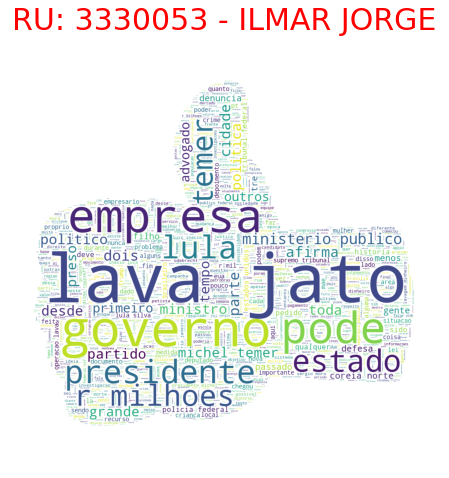

In [13]:
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white', width=1600,
                      height=800, max_words=2000, mask=mask1, max_font_size=1000,
                      min_font_size=1).generate(PalavrasPositivo)

fig, ax = plt.subplots(figsize=(16,8))
plt.title("RU: 3330053 - ILMAR JORGE", fontsize=30, color="red")
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

wordcloud.to_file("positivo.png")


<font size="10">Palavras Negativas</font>

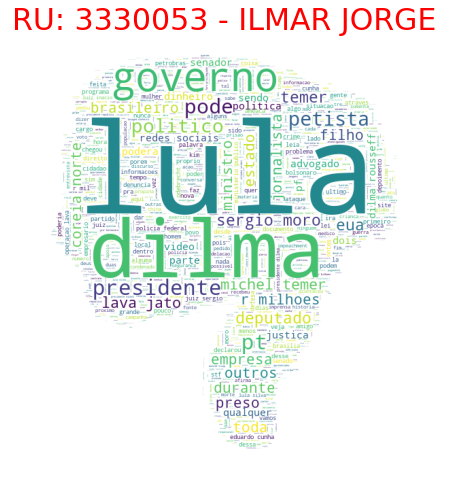

In [14]:
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white', width=1800,
                      height=800, max_words=2000, mask=mask2, max_font_size=1000,
                      min_font_size=1).generate(PalavrasNegativo)

fig, ax = plt.subplots(figsize=(16,8))
plt.title("RU: 3330053 - ILMAR JORGE", fontsize=30, color="red")
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

wordcloud.to_file("negativo.png")

<font size="10">Todas as Palavras</font>

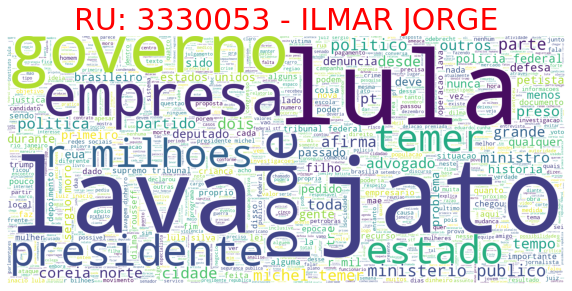

In [15]:
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white', width=1800,
                      height=800, max_words=2000, max_font_size=1000,
                      min_font_size=1).generate(total)

fig, ax = plt.subplots(figsize=(10,8))
plt.title("RU: 3330053 - ILMAR JORGE", fontsize=30, color="red")
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

wordcloud.to_file("tudo.png")

In [17]:
# Total de palavras
positivas = len(PalavrasPositivo)
negativas = len(PalavrasNegativo)

print('Total de palavras positivas: ',positivas)
print('Total de palavras negativas: ',negativas)



Total de palavras positivas:  17421313
Total de palavras negativas:  2942662
